# Pràctica Cas Kaggle 
## CS:GO Competitive Matchmaking Data

### 0. Contexte
#### Què és CS:GO?

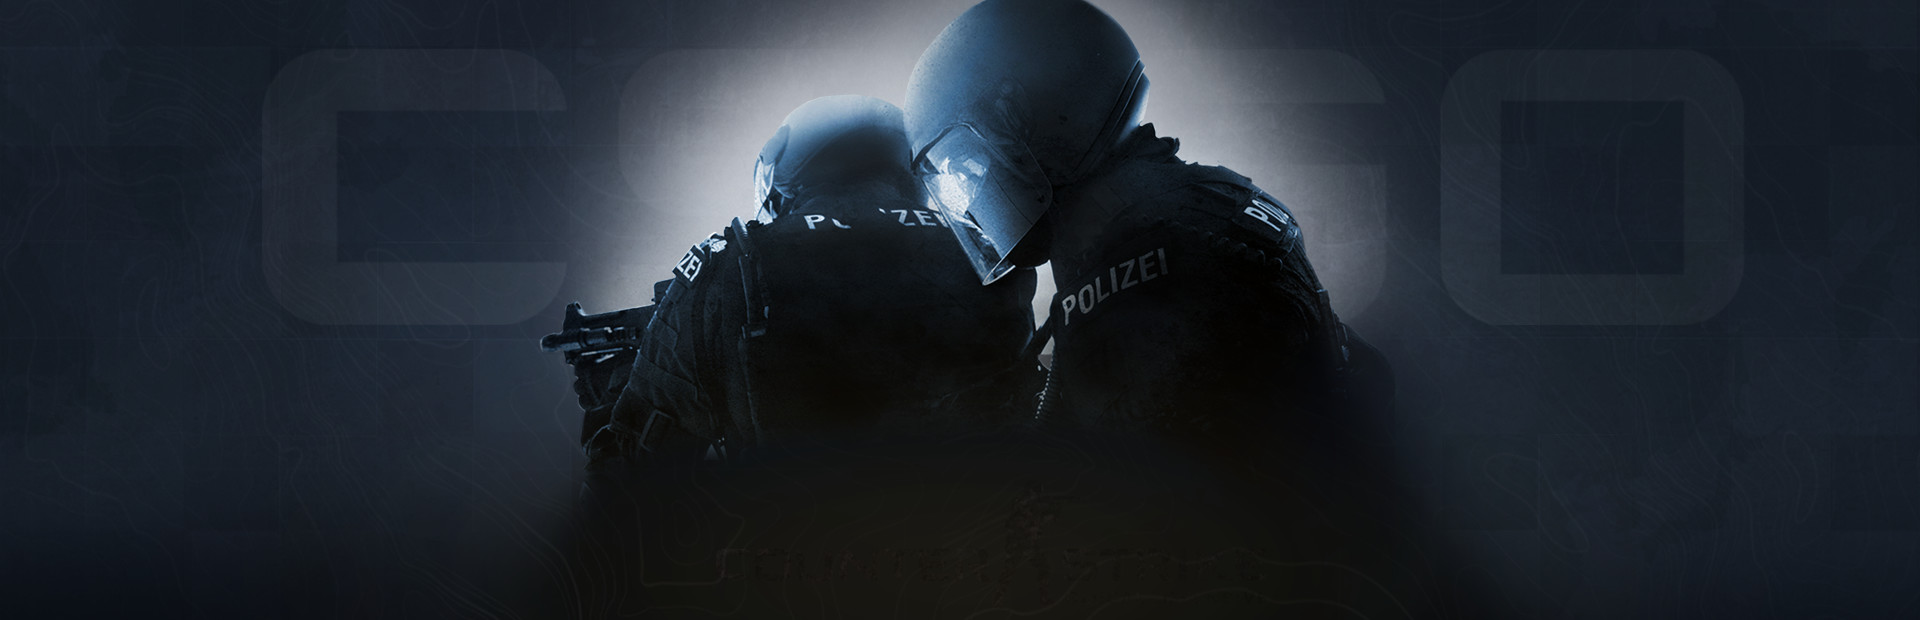

Counter Strike: Global Offensive és un videojoc multijugador gratuit per a ordinadors desenvolupat per Valve Corporation. El mode de joc principal consisteix en que un equip (Terrorists) intenten plantar una bomba en uns punts del mapa (marcats A o B) mentres que l'altre equip (Counter-Terrorists) intenta evitar-lo, i en cas de que la bomba sigui plantada han de desactivar-la.

Altres regles del joc inclouen:
* En cada equip hi ha 5 jugadors.
* Les partides consisteixen de 30 rondes com a màxim.
* Una ronda s'acaba quan un dels equips asoleix l'objectiu o s'acaba el temps. Si s'acaba el temps, guanyen els Counter-Terrorists.
* A partir de la ronda 15, els equips es canvien i es continua jugant fins que un dels equips aconsegueixi 16 rondes guanyades.

#### Xifres
* És un dels videojocs mes jugats i amb millors ingresos econòmics de la plataforma Steam
* Te un pic de al voltant de **1 millió de jugadors simultanis cada dia** [1]
* S'estima el nombre de jugadors totals entre **270 milions i 677.22 milions**[1]. No es un nombre exacte ja que Steam no revela el nombre de jugadors.
* A Twitch, la plataforma d'streaming de partides de videojocs més importants, va tindre un pic de **1,9 milions d'espectadors simultanis** al novembre de 2021. Moltes vegades está en el top 10 de videojocs mes vists[3]
* És una de les principals disciplines d'e-sports en termes de popularitat i reconeixement, amb una comunitat activa i apassionada
* Ofereix una alta quantitat de premis en efectiu i reconeixements als millors jugadors i equips, cosa que atrau molts professionals i aficionats a competir en els tornejos de Counter-Strike.

[1] Source: https://steamdb.info/app/730/graphs/

[2] Source: https://twitchtracker.com/games/32399

[3] Source: https://www.twitch.tv/directory?sort=VIEWER_COUNT

#### La base de dades

El conjunt de dades CS:GO Competitive Matchmaking Data conté informació sobre partides de Counter-Strike: Global Offensive en el mode competitiu. El conjunt de dades inclou informació detallada sobre cada partida, com la data i l'hora en què es va jugar, el mapa, els equips i els jugadors que van participar, i el resultat de la partida.

També inclou informació sobre kills, morts, danys causats, etc. A més, també conté informació sobre les armes i equipament que van utilitzar els jugadors a cada partida.

Aquest conjunt de dades pot ser útil per analitzar i entendre com afecten diferents factors el resultat duna partida de CS:GO, i com es relacionen entre si. També serà útil per fer prediccions sobre el resultat duna partida.

#### Objectiu

L'objectiu és predir quin dels dos sides guanyará la ronda, a partir de les dades de la partida.

### 1. Lectura del dataset

In [47]:
import time as time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
# Funcions per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# La majoria de les dades estan separades en multiples fitxers. Funcio util per a llegir totes les parts
def load_split_dataset(path, parts):
    dataset = pd.concat([pd.read_csv(path + ".part%d.csv" % x, header=0, delimiter=',') for x in range(1,parts+1)])
    return dataset

#### Dades dels mapes

In [3]:
# Carreguem dades dels mapes
map_data = load_dataset('dataset/map_data.csv')
map_data

,Unnamed: 0,EndX,EndY,ResX,ResY,StartX,StartY
0,de_cache,3752,3187,1024,1024,-2031,-2240
1,de_cbble,2282,3032,1024,1024,-3819,-3073
2,de_dust2,2127,3455,1024,1024,-2486,-1150
3,de_inferno,2797,3800,1024,1024,-1960,-1062
4,de_mirage,1912,1682,1024,1024,-3217,-3401
5,de_overpass,503,1740,1024,1024,-4820,-3591
6,de_train,2262,2447,1024,1024,-2436,-2469


Conté informació dels mapes del joc. Nom i cordenades Start i End. "Res" indica la resolució del fitxer PNG que ve inclos amb el dataset per a cada mapa.

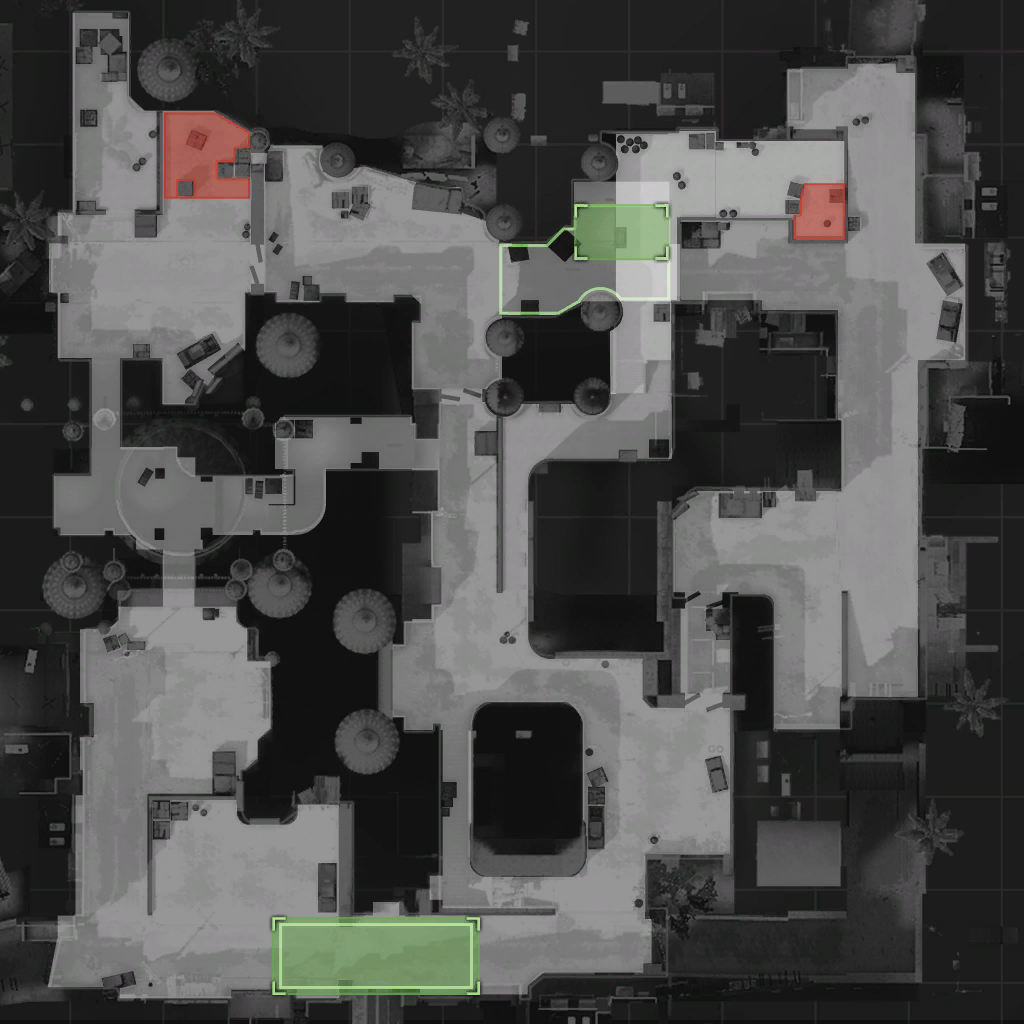
Exemple del mapa "de_dust2"

#### Dades de partides: servidors professionals ESEA https://play.esea.net/

In [4]:
# Carreguem dades de "meta"
meta_data = load_split_dataset('dataset/esea_meta_demos', 2)
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377629 entries, 0 to 161709
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   file           377629 non-null  object 
 1   map            377629 non-null  object 
 2   round          377629 non-null  int64  
 3   start_seconds  377589 non-null  float64
 4   end_seconds    377589 non-null  float64
 5   winner_team    377628 non-null  object 
 6   winner_side    377629 non-null  object 
 7   round_type     377629 non-null  object 
 8   ct_eq_val      377629 non-null  int64  
 9   t_eq_val       377629 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 31.7+ MB


Conté informació general de les partides. Explicació atributs:

**file**: Arxiu "dem" que emmagatzema la repetició de la partida. Identificador

**map**: nom del mapa utilitzat per a jugar la partida.

**round**: Numero de ronda

**start_seconds, end_seconds**: marca de temps en la qual comença / acaba la ronda.

**winner_team, winner_side** (categ.): equip i banda que ha guanyat la ronda.

**round_type** (categ.): tipus de ronda. Ex: NORMAL, PISTOL_ROUND, FORCE_BUY...

**ct_eq_val, t_eq_val**: Valor que ha invertit cada banda en equipament.


In [5]:
# Carreguem dades de "damage"
dmg_data = load_split_dataset('dataset/esea_master_dmg_demos', 2)
dmg_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10538182 entries, 0 to 4546084
Data columns (total 23 columns):
 #   Column           Dtype  
---  ------           -----  
 0   file             object 
 1   round            int64  
 2   tick             int64  
 3   seconds          float64
 4   att_team         object 
 5   vic_team         object 
 6   att_side         object 
 7   vic_side         object 
 8   hp_dmg           int64  
 9   arm_dmg          int64  
 10  is_bomb_planted  bool   
 11  bomb_site        object 
 12  hitbox           object 
 13  wp               object 
 14  wp_type          object 
 15  att_id           int64  
 16  att_rank         int64  
 17  vic_id           int64  
 18  vic_rank         int64  
 19  att_pos_x        float64
 20  att_pos_y        float64
 21  vic_pos_x        float64
 22  vic_pos_y        float64
dtypes: bool(1), float64(5), int64(8), object(9)
memory usage: 1.8+ GB


Explicació atributs:



tick, seconds: Indica el temps. Els ticks son els moments en que s'actualitza el mon del joc, típicament son 64 o 128 ticks per segon. Ofereixen mes precisió pero no els utilitzarem.

att_team, att_side: Equip i banda del jugador que ataca

vic_team, vic_side: Equip i banda de la víctima

hp_dmg:

arm_dmg:

is_bomb_planted: Indica si els terroristes han plantat la bomba.

bomb_site: En cas de que han plantat la bomba, en quin punt es troba? (A o B)

hitbox: On ha encertat la bala al disparar. Exemple: Head, Stomach, Chest... o Generic

wp: Nom de l'arma que ha disparat. Ex: Glock, USP...

wp_type: Tipus de l'arma que ha disparat. Ex: Pistol, Rifle...

att_id, att_rank, vic_id, vic_rank: ID i rang dels dos jugadors. Sembla que hi ha molts missing values i no influeix en la partida. Es pot descartar?

att_pos_x, att_pos_y; vic_pos_x, vic_pos_y: Posicions en el mapa dels dos jugadors.

In [6]:
# Drop atributs que no ens interessen
dmg_data = dmg_data.drop(columns=['tick','att_id','att_rank','vic_id','vic_rank'])

In [7]:
# Carreguem dades de "grenades"
grenades_data = load_split_dataset('dataset/esea_master_grenades_demos', 2)
grenades_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5246458 entries, 0 to 2256397
Data columns (total 23 columns):
 #   Column           Dtype  
---  ------           -----  
 0   file             object 
 1   round            int64  
 2   seconds          float64
 3   att_team         object 
 4   vic_team         object 
 5   att_id           int64  
 6   vic_id           float64
 7   att_side         object 
 8   vic_side         object 
 9   hp_dmg           int64  
 10  arm_dmg          int64  
 11  is_bomb_planted  bool   
 12  bomb_site        object 
 13  hitbox           object 
 14  nade             object 
 15  att_rank         int64  
 16  vic_rank         float64
 17  att_pos_x        float64
 18  att_pos_y        float64
 19  nade_land_x      float64
 20  nade_land_y      float64
 21  vic_pos_x        float64
 22  vic_pos_y        float64
dtypes: bool(1), float64(9), int64(5), object(8)
memory usage: 925.6+ MB


Explicació atributs:

nade:

nade_land_x, nade_land_y:

Utilitzarem aquestes dades?


In [8]:
# Drop atributs que no ens interessen
grenades_data = grenades_data.drop(columns=['att_id','att_rank','vic_id','vic_rank'])

In [9]:
# Carreguem dataset de kills
kills_data = load_split_dataset('dataset/esea_master_kills_demos', 2)
kills_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2742646 entries, 0 to 1173168
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   file             object 
 1   round            int64  
 2   tick             int64  
 3   seconds          float64
 4   att_team         object 
 5   vic_team         object 
 6   att_side         object 
 7   vic_side         object 
 8   wp               object 
 9   wp_type          object 
 10  ct_alive         int64  
 11  t_alive          int64  
 12  is_bomb_planted  bool   
dtypes: bool(1), float64(1), int64(4), object(7)
memory usage: 274.6+ MB


Explicació dels atributs:

ct_alive, t_alive: quants jugadors queden vius en cada banda.

Aquestes dades semblen les mes útils per a fer models. Son mes "globals"

In [10]:
# Drop atributs que no ens interessen
kills_data = kills_data.drop(columns=['tick','att_team','vic_team'])

#### Dades de partides: Matchmaking servidors oficials

In [11]:
# Carregar dades de MM
mm_master_demos = load_dataset('dataset/mm_master_demos.csv')
mm_master_demos.info()

#mm_grenades_demos = load_dataset('dataset/mm_grenades_demos.csv')
#mm_grenades_demos.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955466 entries, 0 to 955465
Data columns (total 33 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       955466 non-null  int64  
 1   file             955466 non-null  object 
 2   map              955466 non-null  object 
 3   date             955466 non-null  object 
 4   round            955466 non-null  int64  
 5   tick             955466 non-null  int64  
 6   seconds          955466 non-null  float64
 7   att_team         955466 non-null  object 
 8   vic_team         955466 non-null  object 
 9   att_side         955466 non-null  object 
 10  vic_side         955466 non-null  object 
 11  hp_dmg           955466 non-null  int64  
 12  arm_dmg          955466 non-null  int64  
 13  is_bomb_planted  955466 non-null  bool   
 14  bomb_site        151039 non-null  object 
 15  hitbox           955466 non-null  object 
 16  wp               955466 non-null  obje

In [12]:
# Drop atributs que no ens interessen
mm_master_demos = mm_master_demos.drop(columns=['tick','date','award','att_id','att_rank','vic_id','vic_rank','avg_match_rank'])

### 2. Anàlisi de les dades

In [13]:
# TODO: preprocesament:
# eliminar outliers? mirar correlacions y todo

In [14]:
# Mostrar tots els equips
meta_data['winner_team'].value_counts()

Team 1                  192564
Team 2                  184262
Team Kinguin                74
Izako Boars                 57
PRiDE                       49
MVP PK                      48
ALTERNATE aTTaX             46
--to be determined--        41
SZ Absolute                 41
EURONICS Gaming             32
Ground Zero                 32
Sprout                      32
AGO Esports                 32
Chiefs                      32
Grayhound                   31
Endpoint                    31
PACT                        27
Dynasty                     25
BOOT-dS Letou               24
SYF                         22
FlashGaming                 19
Legacy                      16
Hentai Hooligans            15
Guerrilla Tactics           15
Taboo                       14
x-kom Team                  11
Animal Style                 9
ONCA Gaming                  8
fish123                      8
Cerus eSports                7
anime savants                4
Name: winner_team, dtype: int64

Hi ha un parell d'equips que son placeholders perque no s'ha registrat quin equip ha guanyat. Aixo fa que no sigui usable, eliminem.

In [15]:
# Eliminem columna
meta_data = meta_data.drop('winner_team', axis=1)
#dmg_data.drop('vic_team', axis=1)
#dmg_data.drop('att_team', axis=1)
#kills_data.drop('vic_team', axis=1)
#kills_data.drop('att_team', axis=1)

#grenades_data.drop('vic_team', axis=1)
#grenades_data.drop('att_team', axis=1)
mm_master_demos = mm_master_demos.drop(columns=['vic_team','att_team'])

<AxesSubplot:ylabel='winner_side'>

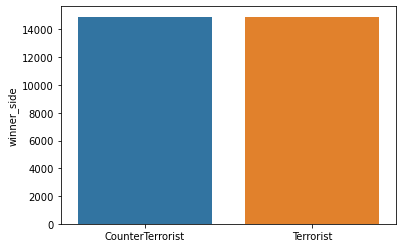

In [16]:
# Quin equip (side) guanya mes? (en ESEA)
side_counts = meta_data.groupby(['file','winner_side']).count().reset_index()['winner_side'].value_counts().head(2)
sns.barplot(x=side_counts.index, y=side_counts)

<AxesSubplot:ylabel='winner_side'>

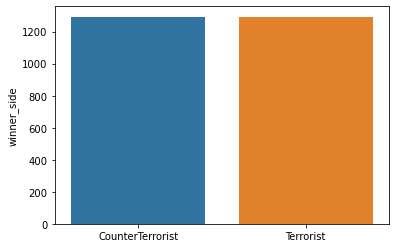

In [17]:
# Quin equip (side) guanya mes? (en matchmaking)
side_counts = mm_master_demos.groupby(['file','winner_side']).count().reset_index()['winner_side'].value_counts()
sns.barplot(x=side_counts.index, y=side_counts)

<AxesSubplot:ylabel='map'>

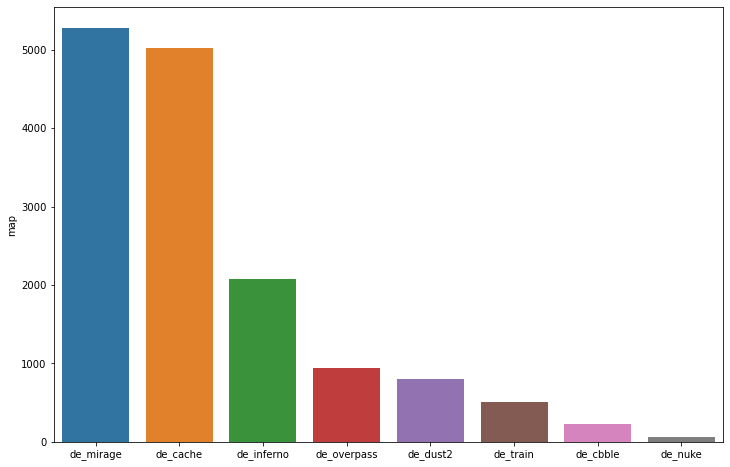

In [18]:
# Quins son els mapes mes populars? (ESEA)
side_counts = meta_data.groupby(['file','map']).count().reset_index()['map'].value_counts().head(10)
plt.subplots(figsize = (12,8))
sns.barplot(x=side_counts.index, y=side_counts)

<AxesSubplot:ylabel='map'>

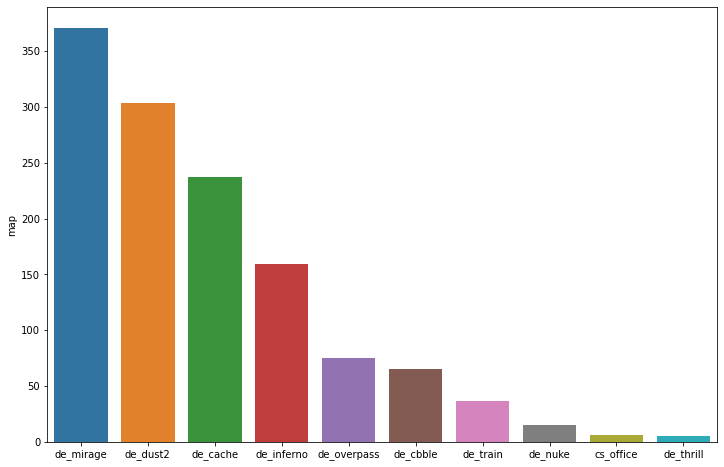

In [19]:
# Quins son els mapes mes populars? (matchmaking)
side_counts = mm_master_demos.groupby(['file','map']).count().reset_index()['map'].value_counts().head(10)
plt.subplots(figsize = (12,8))
sns.barplot(x=side_counts.index, y=side_counts)

In [20]:
# Codificar variables categóriques
meta_data["winner_side"].replace({'Terrorist': 0, 'CounterTerrorist' : 1, 'None' : 1, np.NaN:1}, inplace=True)
#meta_data["round_type"].replace({'PISTOL_ROUND':0, 'ECO':1, 'SEMI_ECO':2, 'NORMAL':3, 'FORCE_BUY':4}, inplace=True)

kills_data["att_side"].replace({'Terrorist': 0, 'CounterTerrorist' : 1, 'None' : -1}, inplace=True)
kills_data["vic_side"].replace({'Terrorist': 0, 'CounterTerrorist' : 1, 'None' : -1}, inplace=True)
kills_data["is_bomb_planted"].replace({False:0, True: 1}, inplace=True)


mm_master_demos["att_side"].replace({'Terrorist': 0, 'CounterTerrorist' : 1, 'None' : np.NaN}, inplace=True)
mm_master_demos["vic_side"].replace({'Terrorist': 0, 'CounterTerrorist' : 1, 'None' : np.NaN}, inplace=True)
mm_master_demos["winner_side"].replace({'Terrorist': 0, 'CounterTerrorist' : 1, 'None' : 1, np.NaN:1}, inplace=True)
mm_master_demos["bomb_site"].replace({np.NaN:-1, 'A': 0, 'B' : 1}, inplace=True)
mm_master_demos["hitbox"].replace({'Head': 0, 'RightLeg' : 1, 'LeftLeg': 2, 'Chest':3, 'Stomach': 4, 'RightArm': 5, 'Generic': 6, 'LeftArm': 7}, inplace=True)
mm_master_demos["wp"].replace({'USP':0, 'Glock':1, 'P2000':2, 'HE':3, 'Tec9':4, 'Deagle':5, 'MP9':6, 'UMP':7, 'Famas':8, 'P250':9, 'AK47':10, 'AWP':11, 'MP7':12, 'M4A1':13, 'FiveSeven':14, 'Incendiary':15, 'Scout':16, 'Unknown':17, 'Knife':18, 'Bizon':19, 'Flash':20, 'CZ':21, 'M4A4':22, 'Molotov':23, 'P90':24, 'AUG':25, 'Gallil':26, 'G3SG1':27, 'M249':28, 'SG556':29, 'Mac10':30, 'XM1014':31, 'DualBarettas':32, 'Nova':33, 'Swag7':34, 'Zeus':35, 'Scar20':36, 'SawedOff':37, 'Smoke':38, 'Negev':39, 'Decoy':40, 'Bomb':41}, inplace=True)
mm_master_demos["wp_type"].replace({'Pistol':0, 'Grenade':1, 'SMG':2, 'Rifle':3, 'Sniper':4, 'Unkown':5, 'Equipment':6, 'Heavy':7}, inplace=True)
#mm_master_demos["round_type"].replace({'PISTOL_ROUND':0, 'ECO':1, 'SEMI_ECO':2, 'NORMAL':3, 'FORCE_BUY':4}, inplace=True)


# One-hot encoding
#round type y map TODO

In [21]:
mm_master_demos["round_type"].unique()

array(['PISTOL_ROUND', 'ECO', 'SEMI_ECO', 'NORMAL', 'FORCE_BUY'],
      dtype=object)

array([[<AxesSubplot:title={'center':'round'}>,
        <AxesSubplot:title={'center':'start_seconds'}>],
       [<AxesSubplot:title={'center':'end_seconds'}>,
        <AxesSubplot:title={'center':'winner_side'}>],
       [<AxesSubplot:title={'center':'ct_eq_val'}>,
        <AxesSubplot:title={'center':'t_eq_val'}>]], dtype=object)

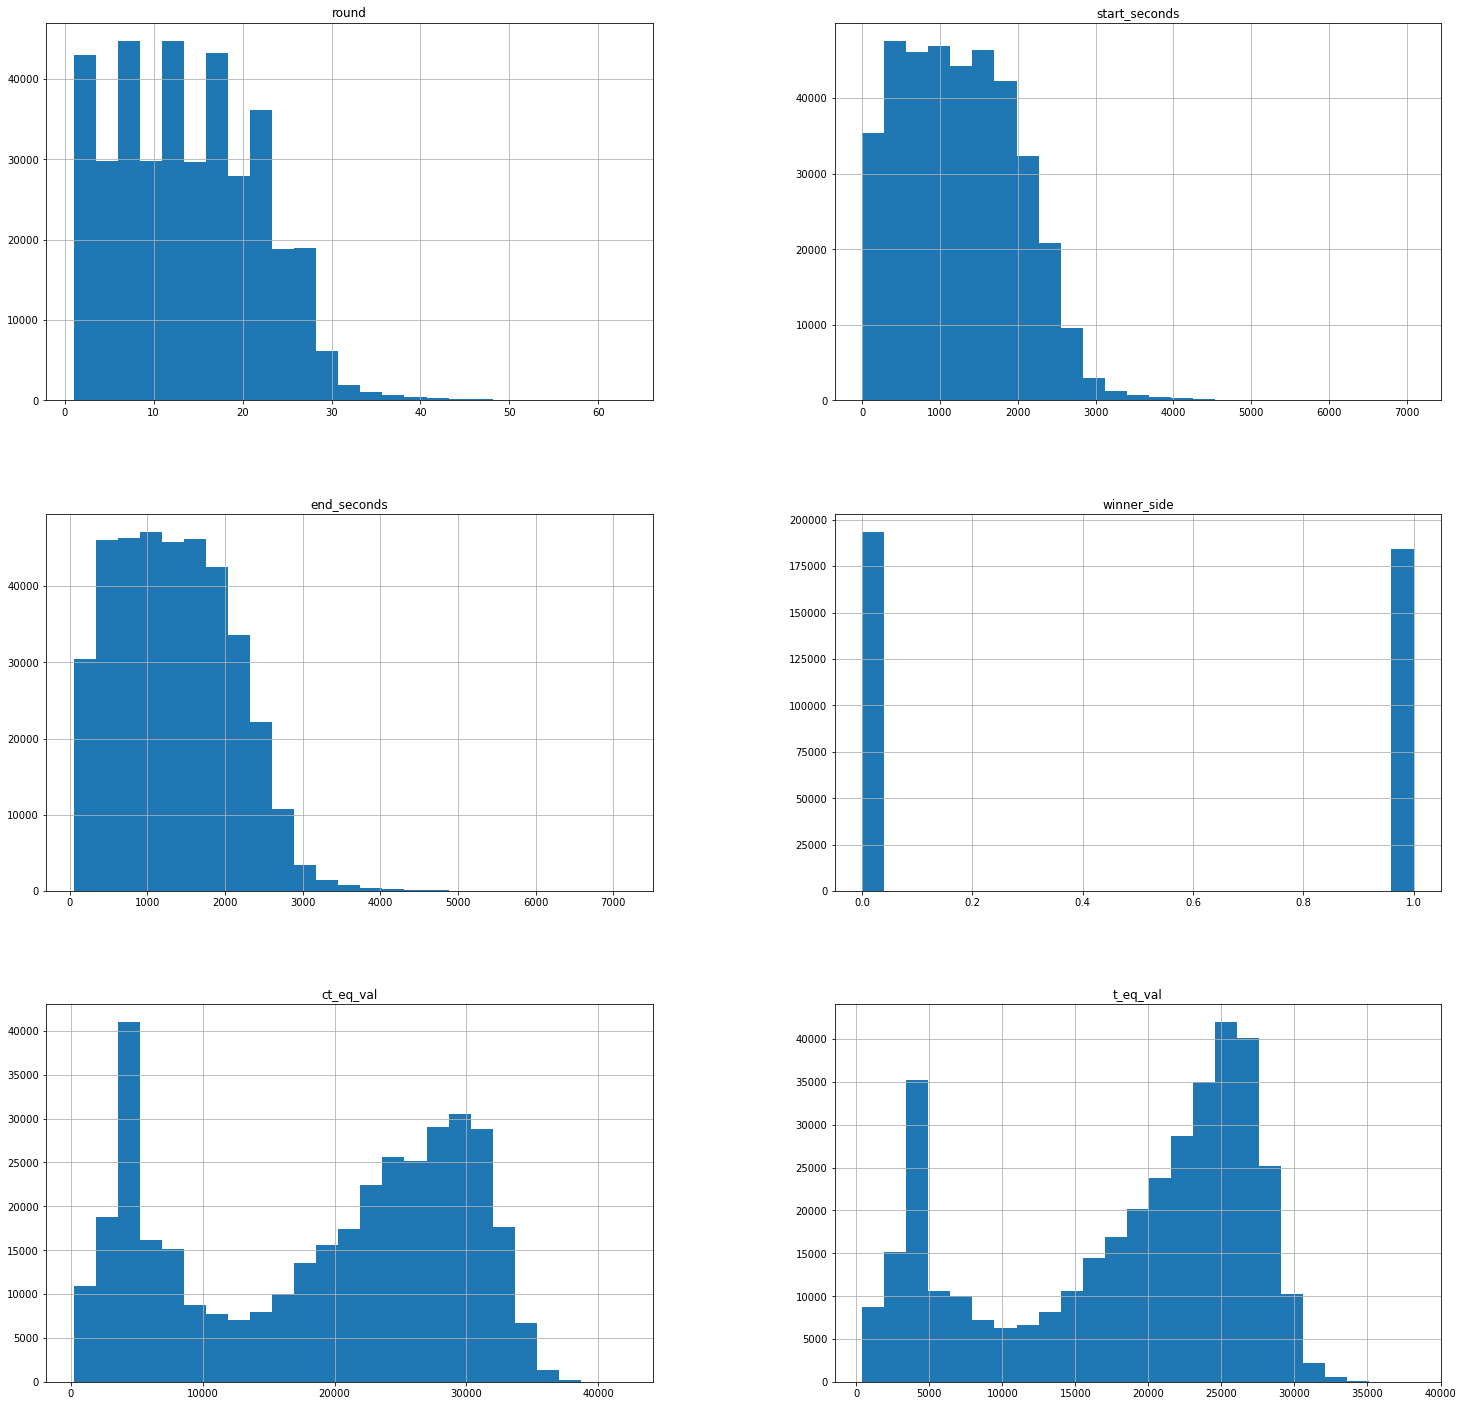

In [22]:
# Generar histogrames, general
meta_data.hist(bins=25, figsize=(25, 25))

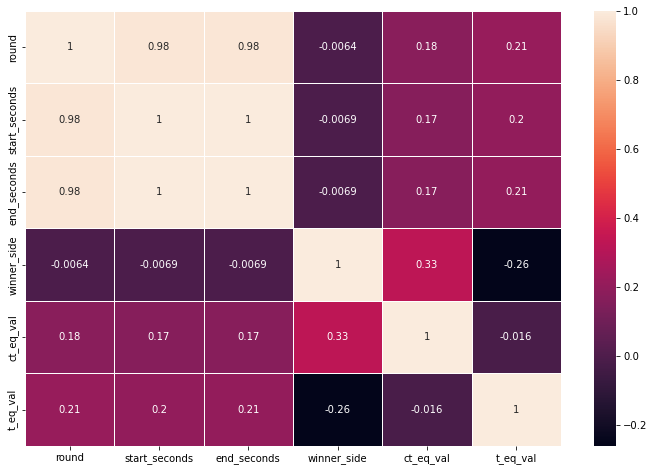

In [23]:
correlacio = meta_data.corr()
plt.subplots(figsize = (12,8))
#plt.figure()
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

In [24]:
# explicar aqui correlacion

#### Quines dades utilitzarem per a fer machine learning?
Les dades que trobem als dataframes de grenades i dmg aporten informació massa precisa d'un moment en concret del joc. Necessitem dades mes globals, com les que trobem a kills i meta. En el cas de MM, no utilitzarem aquestes dades perque no tenim dades de les "kills" i tenim el mateix problema que amb les dades de granedes i dmg.

In [25]:
# No farem servir dades de "grenades" ni "damage", nomes de "kills". Eliminem les dades carregades per estalviar memòria.
del(grenades_data)
del(dmg_data)
del(mm_master_demos)

Farem servir els seguents atributs:
* Numero de ronda
* Quants jugadors T queden vius
* Quants jugadors CT queden vius
* La bomba ha sigut plantada (pels T)
* Quantitat invertida en armes pels T
* Quantitat invertida en armes pels CT

In [26]:
# pca y eso? necesario?

### 3. Implementació de models

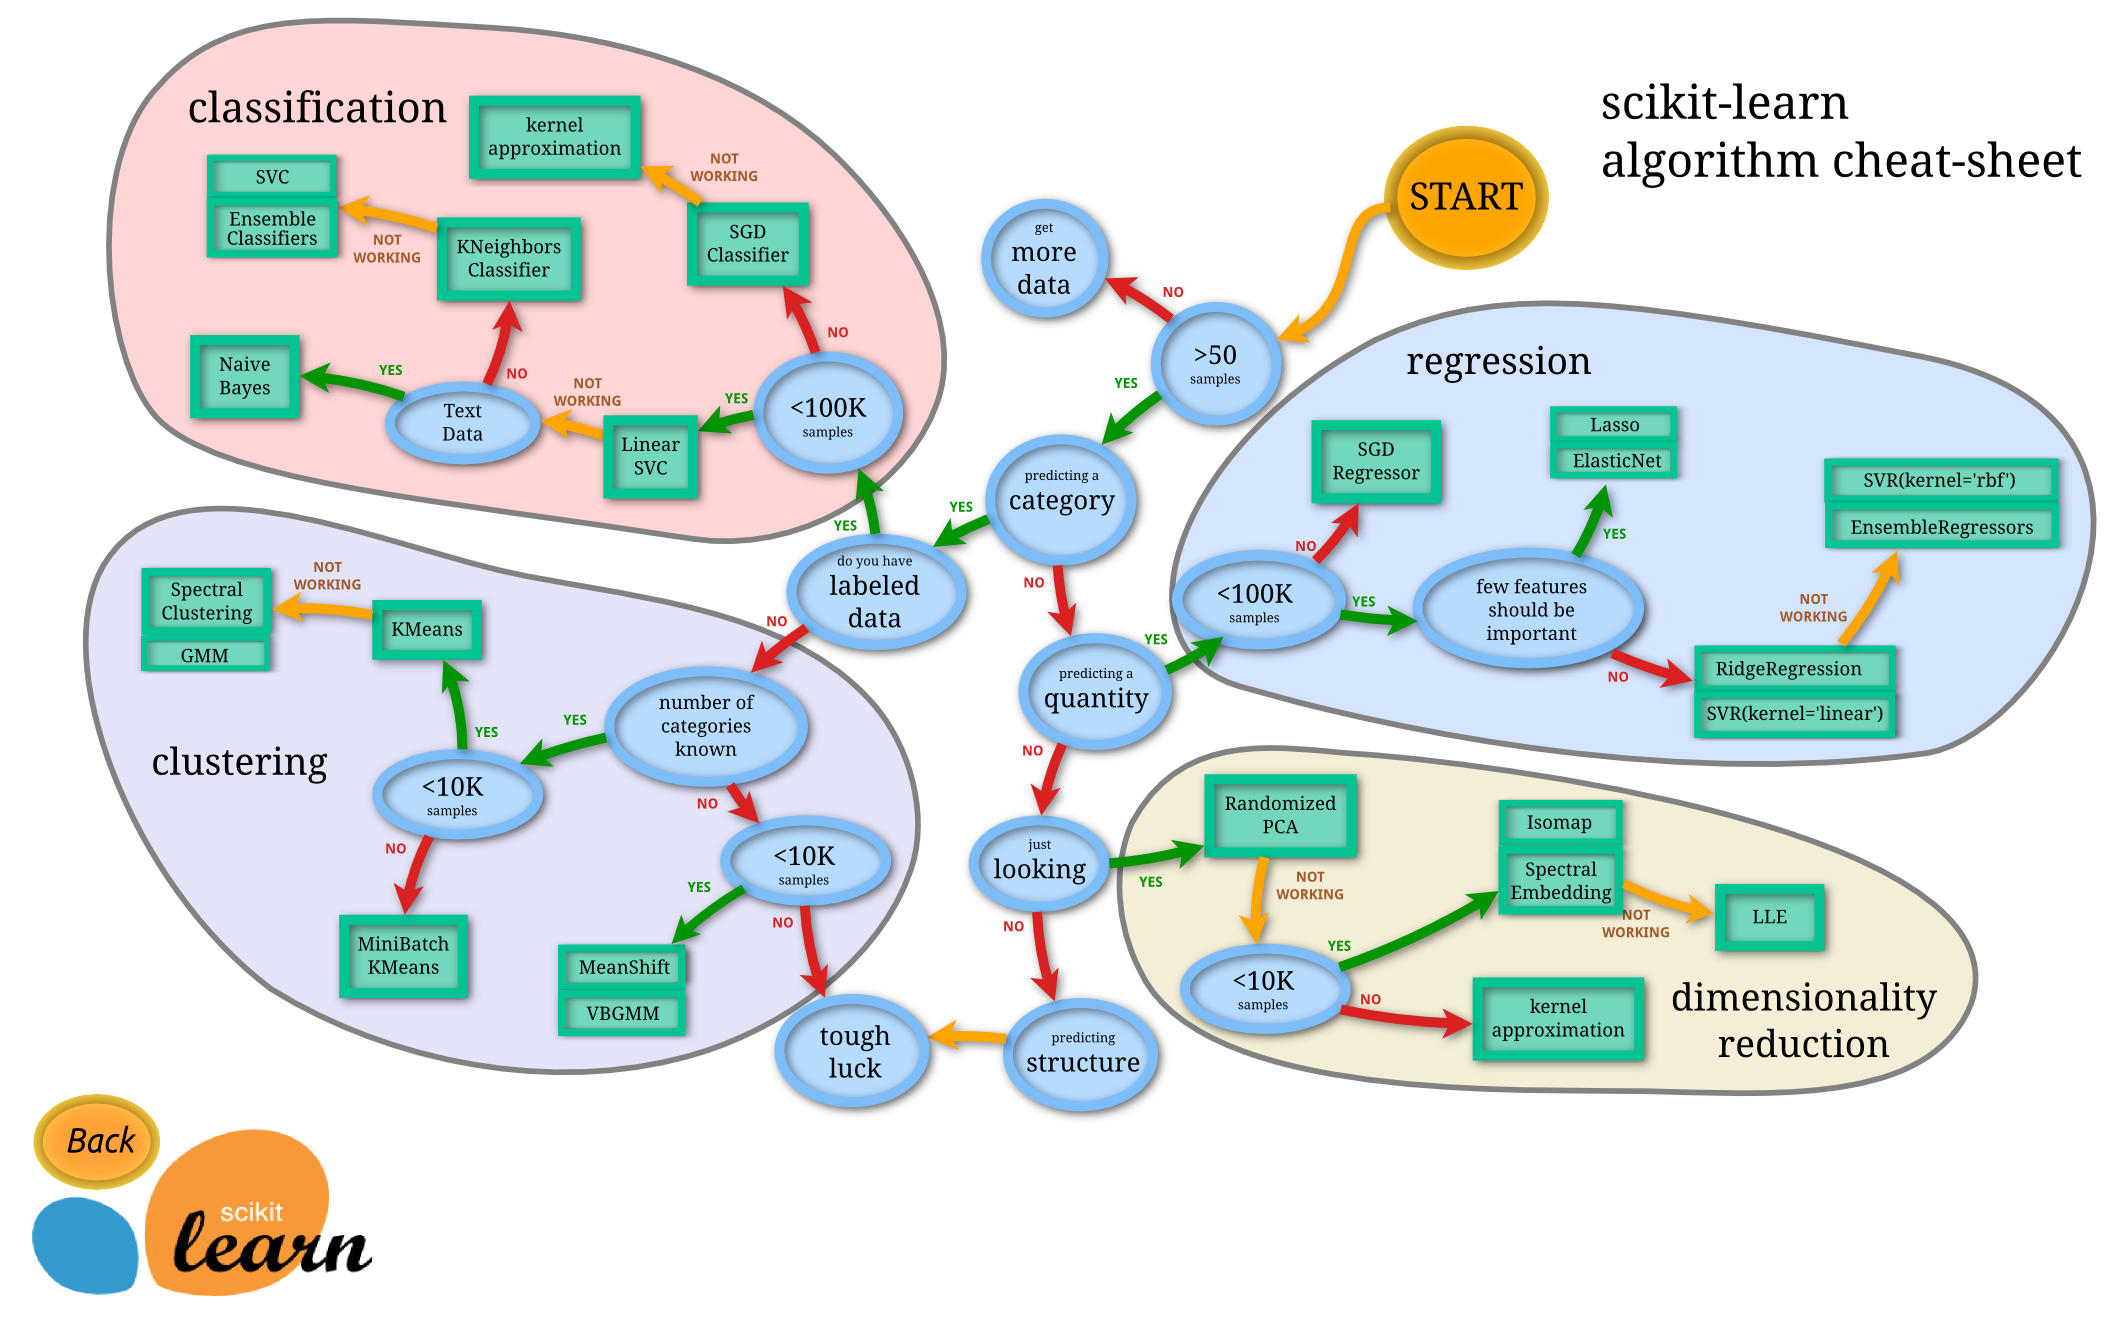

Esquema de models de sckit learn, extret de https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

El nostre objectiu es predir una categoria (quina banda guanya una ronda). Podem utilitzar els següents models:
* Regressió logística
* Linear SVC...
* Arbres de decisió
* KNeighbours Classifier?
* Random forest?
* Multi-layer perceptron?

In [27]:
# Juntar dades de meta_data i kills_data
m = pd.merge(kills_data, meta_data)
y = m['winner_side']
X = m[['round','ct_alive','t_alive','is_bomb_planted','ct_eq_val','t_eq_val']]

# Dividir dades entre test i train
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.33)

#### Regressió logistica

In [30]:
# Regressió logistica (train)
start = time.time()  # Get the current time
logr = LogisticRegression()
logr.fit(X_train, y_train)
# Falta cross-validation?


# Calculate the time difference
time_elapsed = time.time() - start
print(f"Time elapsed: {time_elapsed} seconds")

Time elapsed: 3.2432827949523926 seconds


In [43]:
y_pred = logr.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82    458144
           1       0.81      0.81      0.81    432229

    accuracy                           0.81    890373
   macro avg       0.81      0.81      0.81    890373
weighted avg       0.81      0.81      0.81    890373



In [44]:
y_pred = logr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82    929716
           1       0.81      0.81      0.81    878012

    accuracy                           0.81   1807728
   macro avg       0.81      0.81      0.81   1807728
weighted avg       0.81      0.81      0.81   1807728



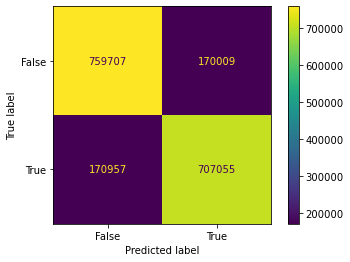

In [48]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show() 

In [ ]:
# Cross-validation?

#### Linear SVC

In [35]:
# Linear SVC
start = time.time()  # Get the current time
clf = LinearSVC()
clf.fit(X_train, y_train)

time_elapsed = time.time() - start
print(f"Time elapsed: {time_elapsed} seconds")


y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Time elapsed: 181.736008644104 seconds
              precision    recall  f1-score   support

           0       0.93      0.53      0.68    929716
           1       0.66      0.95      0.78    878012

    accuracy                           0.74   1807728
   macro avg       0.79      0.74      0.73   1807728
weighted avg       0.80      0.74      0.73   1807728



#### Arbres de decisió

In [42]:
# 
start = time.time()  # Get the current time
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

time_elapsed = time.time() - start
print(f"Time elapsed: {time_elapsed} seconds")


y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

Time elapsed: 4.142355680465698 seconds
              precision    recall  f1-score   support

           0       0.75      0.76      0.76    929716
           1       0.74      0.74      0.74    878012

    accuracy                           0.75   1807728
   macro avg       0.75      0.75      0.75   1807728
weighted avg       0.75      0.75      0.75   1807728



#### KNeighbours Classifier

In [37]:
# KNN IAAA
start = time.time()  # Get the current time
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

time_elapsed = time.time() - start
print(f"Time elapsed: {time_elapsed} seconds")


y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

Time elapsed: 3.5017051696777344 seconds
              precision    recall  f1-score   support

           0       0.80      0.80      0.80    929716
           1       0.79      0.78      0.79    878012

    accuracy                           0.79   1807728
   macro avg       0.79      0.79      0.79   1807728
weighted avg       0.79      0.79      0.79   1807728



#### Random forest

In [38]:
# Random Forest
start = time.time()  # Get the current time
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

time_elapsed = time.time() - start
print(f"Time elapsed: {time_elapsed} seconds")


y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

Time elapsed: 146.52396512031555 seconds
              precision    recall  f1-score   support

           0       0.80      0.80      0.80    929716
           1       0.79      0.79      0.79    878012

    accuracy                           0.80   1807728
   macro avg       0.80      0.80      0.80   1807728
weighted avg       0.80      0.80      0.80   1807728



#### Multi-layer perceptron

In [39]:
# Multi-layer perceptron. Falta hyper? no va
start = time.time()  # Get the current time
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train)

time_elapsed = time.time() - start
print(f"Time elapsed: {time_elapsed} seconds")


y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

Time elapsed: 2.9018023014068604 seconds


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.51      1.00      0.68    929716
           1       0.00      0.00      0.00    878012

    accuracy                           0.51   1807728
   macro avg       0.26      0.50      0.34   1807728
weighted avg       0.26      0.51      0.35   1807728



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 4. Comparació de models

In [40]:
# cosas

### 5. Anàlisi de resultats

In [41]:
#cosas

### 6. Final

#### Conclusions
Conclusions...

#### Treballs futurs
Com no es tracta d'un entorn real, on seria molt aconseguir captar totes les dades en temps real, i es tracta d'un videojoc, on tenim totes les dades en memoria, es podria desenvolupar un "programa" que capti el estat d'una partida competitiva de Counter Strike i que vagi predint en tot moment quin sera el resultat de la ronda. Per aixo s'hauria de millorar els models utilitzant menys dades "globals" (numero de jugadors restant de cada equip) i utilitzar dades mes "de cada moment" (posicio de la bomba, utilitzar dades del "dmg" i de les granades...)